# 0. Import library

In [2]:
import os
import json
import numpy as np
import cv2

from time import time
from pickle import dump, load
from PIL import Image

import keras_cv
from keras_cv import visualization

import collections
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Using TensorFlow backend


In [3]:
from tensorflow.data import Dataset
from tensorflow.train import Checkpoint

from tensorflow.nn import tanh, softmax
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import sparse_categorical_crossentropy, SparseCategoricalCrossentropy

# 1. Dataset


## Import dataset (read from JSON file)

The dataset contains only 2468 images (from coco2017val) with 5 captions per an image
- /images: contains 2468 images
- /captions: contains 2468 .txt files, each file represents 5 captions of the corresponding image
- /instances: contains 2468 txt file, each file represents instances of the corresponding image
- /classes.txt: all object classes


In [5]:
DATASET_FOLDER_PATH = 'dataset'
IMAGE_FOLDER_PATH = 'images'
CAPTION_FOLDER_PATH = 'captions'
INSTANCE_FOLDER_PATH = 'instances'

img_files = os.listdir(os.path.join(DATASET_FOLDER_PATH, IMAGE_FOLDER_PATH))
caption_files = os.listdir(os.path.join(DATASET_FOLDER_PATH, CAPTION_FOLDER_PATH))
instance_files = os.listdir(os.path.join(DATASET_FOLDER_PATH, INSTANCE_FOLDER_PATH))
NUM_IMAGES = len(img_files)
idx_train = int(NUM_IMAGES * 0.75)

### Show an example

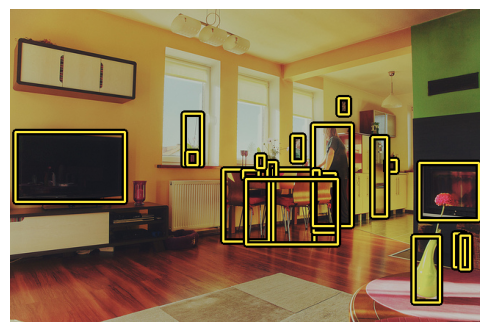

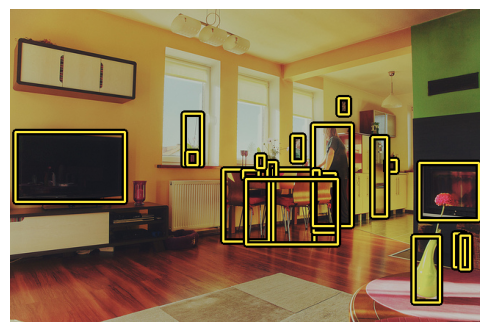

In [6]:
idx = 0
img_file = img_files[idx]

image = Image.open(os.path.join(DATASET_FOLDER_PATH, IMAGE_FOLDER_PATH, img_file))
image = np.array([image])

f_instances = open(os.path.join(DATASET_FOLDER_PATH, INSTANCE_FOLDER_PATH, img_file[:-3] + 'txt'))
instances = f_instances.readlines()

num_detections = len(instances)
boxes = list()
classes = list()
for instance in instances:
    box_info = instance.split()
    classes.append(int(box_info[0]))
    boxes.append(list(map(float, box_info[1:])))

img_annotations = {
    'boxes': np.array([boxes]),
    'confidence': np.ones((1, num_detections)),
    'classes': np.array([classes]),
    'num_detections': np.array([num_detections])
}

visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=img_annotations,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh'
)

## Preprocess captions

Preprocess a caption

In [7]:
import unicodedata
import re

# Convert the unicode sequence to ascii
def unicode_to_ascii(s):

  # Normalize the unicode string and remove the non-spacking mark
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):

  # Clean the sequence
  w = unicode_to_ascii(w.lower().strip())

  # Create a space between word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # Add a start and stop token to detect the start and end of the sequence
  w = '<start> ' + w + ' <end>'
  return w

## Caption tokenizer

In [8]:
# Convert sequences to tokenizers
def tokenize(lang):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

  # Convert sequences into internal vocab
  tokenizer.fit_on_texts(lang)

  # Convert internal vocab to numbers
  tensor = tokenizer.texts_to_sequences(lang)

  # Pad the tensors to assign equal length to all the sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, tokenizer

preprocessed_captions: a list of all captions

In [9]:
preprocessed_captions = list()
for captions in caption_files:
    f_captions = open(os.path.join(DATASET_FOLDER_PATH, CAPTION_FOLDER_PATH, captions), 'r')
    for caption in f_captions.readlines()[:5]:
        preprocessed_captions.append(preprocess_sentence(caption))
        
len(preprocessed_captions)

12340

In [10]:
captions_tensor, tokenizer = tokenize(preprocessed_captions)

# Calculate max_length of the caption tensor
max_length_caption = captions_tensor.shape[1]

captions_tensor.shape

(12340, 56)

In [11]:
# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ()
print ("Train dataset; index to word mapping")
convert(tokenizer, captions_tensor[0])


Train dataset; index to word mapping
2 ----> <start>
1 ----> a
25 ----> woman
200 ----> stands
8 ----> in
7 ----> the
278 ----> dining
102 ----> area
15 ----> at
7 ----> the
21 ----> table
4 ----> .
3 ----> <end>


## Feature extraction model

Instead of using an object detection model, use labeld bboxes from dataset to choose objects (top 5 area with maximum area)

In [12]:
def instance_area(instance):
  _, _, width, height = instance
  return width * height

In [13]:
def xywh_to_yxyx(box):
  x, y, w, h = box
  return [y, x, y + h, x + w]

In [14]:
def normalize_box(box, width, height):
  y1, x1, y2, x2 = box
  return [y1 / height, x1 / width, y2 / height, x2 / width]

All resized images -> image_batch -> shape: (8, 512, 512, 3)

Crop all bboxes from an image and resize -> objects_batch -> shape: (40, 512, 512, 3)

In [15]:
MAXIMUM_OBJECTS = 5
CROP_SIZE = (512, 512)

resizing_layer = keras_cv.layers.Resizing(512, 512, pad_to_aspect_ratio=True, bounding_box_format="yxyx")

BATCH_SIZE = 32
image_full = list()
objects_full = list()


for i in range(0, idx_train, BATCH_SIZE):
    print(f"BATCH {i}...")
    
    image_batch = list()
    boxes = list()
    box_indices = list()
    
    idx_max = min(i + BATCH_SIZE, idx_train)
    
    for idx, img_file in enumerate(img_files[i : idx_max]):
        
        image = cv2.imread(os.path.join(DATASET_FOLDER_PATH, IMAGE_FOLDER_PATH, img_file))
        image = resizing_layer(image)
        image_batch.append(image)

        f_instances = open(os.path.join(DATASET_FOLDER_PATH, INSTANCE_FOLDER_PATH, img_file[:-3] + 'txt'), 'r')
        instances = f_instances.readlines()
        num_objects = min(len(instances), MAXIMUM_OBJECTS)
        sorted_area_instances = list()
        for instance in instances:
            sorted_area_instances.append(list(map(float, instance.split()[1:])))
            sorted_area_instances = sorted(sorted_area_instances, key=lambda d: instance_area(d), reverse=True)

            top_selected_instances = sorted_area_instances[:num_objects]
            top_selected_instances = [xywh_to_yxyx(xywh_box) for xywh_box in top_selected_instances]
            top_selected_instances = [normalize_box(box, 511, 511) for box in top_selected_instances]

        boxes.extend(top_selected_instances)

        # Crop the detected objects
        box_index = np.empty(shape=(num_objects,), dtype=np.int32)
        box_index.fill(idx)
        box_indices.extend(box_index)

    image_batch = np.array(image_batch)
    boxes = np.array(boxes)
    box_indices = np.array(box_indices)
    objects_batch = tf.image.crop_and_resize(image_batch, boxes, box_indices, CROP_SIZE)
    
    image_full.extend(list(image_batch))
    objects_full.extend(list(objects_batch))
    
image_full = np.array(image_full)
objects_full = np.array(objects_full)

image_full.shape
objects_full.shape


BATCH 0...
BATCH 32...
BATCH 64...
BATCH 96...
BATCH 128...
BATCH 160...
BATCH 192...
BATCH 224...
BATCH 256...
BATCH 288...
BATCH 320...
BATCH 352...
BATCH 384...
BATCH 416...
BATCH 448...
BATCH 480...
BATCH 512...
BATCH 544...
BATCH 576...
BATCH 608...
BATCH 640...
BATCH 672...
BATCH 704...
BATCH 736...
BATCH 768...
BATCH 800...
BATCH 832...
BATCH 864...
BATCH 896...
BATCH 928...
BATCH 960...
BATCH 992...
BATCH 1024...
BATCH 1056...
BATCH 1088...
BATCH 1120...


MemoryError: Unable to allocate 96.0 MiB for an array with shape (32, 512, 512, 3) and data type float32

In [ ]:
visualization.plot_image_gallery(
    image_batch[:8],
    value_range=(0, 255),
    rows=2,
    cols=4,
    scale=5,
)

In [ ]:
visualization.plot_image_gallery(
    objects_batch[0:40],
    value_range=(0, 255),
    rows=8,
    cols=5,
    scale=5,
)

### Image processing: Feature extraction


Use a backbone CNN model (ResNet50) to extract features from an image and correspond objects

outputs_backbone -> shape: (8, 6, 256)

In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

In [38]:
backbone_model = ResNet50(
    input_shape=(224, 224, 3)
)

new_input = backbone_model.input
final_layer = backbone_model.output
output = Dense(units=256, name="resize")(final_layer)

feature_extraction_model = Model(
    inputs=new_input, 
    outputs=output
)

In [39]:
def concat_image_and_objects(image, objects):
    # Resize image and objects to fit the backbone's input
    image_input = np.resize(image, (224, 224, 3))
    objects_input = np.resize(objects, (objects.shape[0], 224, 224, 3))
    # Concat image and objects
    input_backbone = tf.concat(axis=0, values=[tf.expand_dims(image_input, 0), objects_input])
    input_backbone = preprocess_input(input_backbone)
    output_backbone = feature_extraction_model(input_backbone)

    return output_backbone

In [40]:
outputs_backbone = []

for i, image in enumerate(image_batch):
  objects = objects_batch[5 * i : 5 * i + 5]
  output_backbone = concat_image_and_objects(image, objects)
  outputs_backbone.append(output_backbone)

outputs_backbone = np.array(outputs_backbone)
outputs_backbone.shape

(8, 6, 256)

In [41]:
# The array contains indexes to image features
images_feature_index = list()
for i in range(NUM_IMAGES):
    images_feature_index.extend([i] * 5)

images_feature_index = np.array(images_feature_index)
images_feature_index

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7])

## Create dataset

In [78]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
caption_tensor_train, caption_tensor_val, img_feature_idx_train, img_feature_idx_val = train_test_split(captions_tensor, images_feature_index, test_size=0.25, shuffle=False)

print(len(caption_tensor_train), len(img_feature_idx_train), len(caption_tensor_val), len(img_feature_idx_val))

30 30 10 10


# 4. Model

In [83]:
BUFFER_SIZE = 30
BATCH_SIZE = 30
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 256
vocab_size = len(tokenizer.word_index) + 1

In [84]:
dataset = tf.data.Dataset.from_tensor_slices((caption_tensor_train, img_feature_idx_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [85]:
# Size of input and target batches
example_captions_batch, example_image_features_index_batch = next(iter(dataset))
example_captions_batch.shape, example_image_features_index_batch.shape

(TensorShape([30, 20]), TensorShape([30]))

## 4.2 Attention Class

In [86]:
# Attention class - Additive Attention - a Soft Attention technique
class AdditiveAttention(Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [87]:
imgs_feature_batch = [outputs_backbone[i] for i in example_image_features_index_batch]
imgs_feature_batch = np.array(imgs_feature_batch)

imgs_feature_batch.shape

(30, 6, 256)

In [88]:
sample_hidden = tf.zeros((BATCH_SIZE, units))

attention_layer = AdditiveAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, imgs_feature_batch)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (30, 256)
Attention weights shape: (batch_size, sequence_length, 1) (30, 6, 1)


## 4.3 Decoder Class

In [89]:
# Decoder class
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size * 5
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)

        self.gru = GRU(self.dec_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer='glorot_uniform')
        self.fc = Dense(vocab_size)

        self.attention = AdditiveAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [92]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_input = tf.random.uniform((BATCH_SIZE, 1))
sample_decoder_output, _, _ = decoder(sample_decoder_input,
                                      sample_hidden, imgs_feature_batch)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (30, 137)


## 4.4 Optimizer and Loss function

In [93]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [94]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                        decoder=decoder)

In [95]:
@tf.function
def train_step(targ, output_backbone):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = tf.zeros((BATCH_SIZE, units))

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, output_backbone)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [96]:
import time

EPOCHS = 100

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  total_loss = 0

  # Loop through the dataset
  for (batch, (caption, feature_idx)) in enumerate(dataset.take(steps_per_epoch)):
  # for caption, output_backbone in zip(captions_dataset, outputs_backbone):
    output_backbone = outputs_backbone[feature_idx]

    # Call the train method
    batch_loss = train_step(caption, output_backbone)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 10 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every epochs
  checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8769
Epoch 1 Loss 2.8769
Time taken for 1 epoch 21.786938190460205 sec

Epoch 2 Batch 0 Loss 2.8675
Epoch 2 Loss 2.8675
Time taken for 1 epoch 0.09795498847961426 sec

Epoch 3 Batch 0 Loss 2.8579
Epoch 3 Loss 2.8579
Time taken for 1 epoch 0.12039518356323242 sec

Epoch 4 Batch 0 Loss 2.8479
Epoch 4 Loss 2.8479
Time taken for 1 epoch 0.1056218147277832 sec

Epoch 5 Batch 0 Loss 2.8374
Epoch 5 Loss 2.8374
Time taken for 1 epoch 0.1006772518157959 sec

Epoch 6 Batch 0 Loss 2.8263
Epoch 6 Loss 2.8263
Time taken for 1 epoch 0.09093785285949707 sec

Epoch 7 Batch 0 Loss 2.8143
Epoch 7 Loss 2.8143
Time taken for 1 epoch 0.09967923164367676 sec

Epoch 8 Batch 0 Loss 2.8015
Epoch 8 Loss 2.8015
Time taken for 1 epoch 0.10105276107788086 sec

Epoch 9 Batch 0 Loss 2.7876
Epoch 9 Loss 2.7876
Time taken for 1 epoch 0.10870695114135742 sec

Epoch 10 Batch 0 Loss 2.7725
Epoch 10 Loss 2.7725
Time taken for 1 epoch 0.10018658638000488 sec

Epoch 11 Batch 0 Loss 2.7562
Epoch 11 Los

# Evaluate the model

In [126]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(image_id):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_caption, MAXIMUM_OBJECTS + 1))

  # Object detection and extract features from image
  img_and_objects_features = outputs_backbone[image_id]

  result = ''

  dec_hidden = tf.zeros((1, units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_caption):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         img_and_objects_features)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += tokenizer.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, attention_plot

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [112]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))